In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import math

In [3]:
# Load in the data
data_day = pd.read_csv('day.csv')
data_hour = pd.read_csv('hour.csv')

In [4]:
# Set what evening means
evening_hrs = np.arange(16, 19)

# set what is spring and summer
season = {'winter': 1,
          'spring': 2,
          'summer': 3,
          'autumn': 4}

In [5]:
# create df only looking at evening hours, and their respective season
data_spring_workday = data_hour[(data_hour['hr'].isin(evening_hrs)) &
                                (data_hour['season']==season['spring']) &
                                (data_hour['workingday']==1)]
data_summer_workday = data_hour[(data_hour['hr'].isin(evening_hrs)) &
                                (data_hour['season']==season['summer']) &
                                (data_hour['workingday']==1)]

# now summarise the data so each line in data represents one sample event, ie. the total number of bike hires 
# during peak commuting times on a single day
data_spring_eve_workday = data_spring_workday.groupby(['dteday', 'weekday'])[['casual', 'registered', 'cnt']].sum()
data_summer_eve_workday = data_summer_workday.groupby(['dteday', 'weekday'])[['casual', 'registered', 'cnt']].sum()

# get the weather, temp and hum info average for the evening on that day
data_spring_eve_workday_weather = data_spring_workday.groupby(['dteday', 'weekday'])[['weathersit', 'temp', 'atemp', 'weathersit', 'hum', 'windspeed']].mean()
data_summer_eve_workday_weather = data_summer_workday.groupby(['dteday', 'weekday'])[['weathersit', 'temp', 'atemp', 'weathersit', 'hum', 'windspeed']].mean()

# join average weather data to bike counts
data_spring_eve_workday = pd.concat([data_spring_eve_workday, data_spring_eve_workday_weather], axis=1)
data_summer_eve_workday = pd.concat([data_summer_eve_workday, data_summer_eve_workday_weather], axis=1)

# remove weekday and date being the index - change to just row number being index:
data_spring_eve_workday.reset_index(inplace=True)
data_summer_eve_workday.reset_index(inplace=True)

### Complete some quick checks
Check we get expected results when we compare our transformed data to the original data

In [6]:
# Quick sense check on the size of the new data sets
# number of working days in data_day should be the same as number of rows in summer_eve + spring_eve

print(f"spring shape: {data_spring_eve_workday.shape}")
print(f"summer shape: {data_summer_eve_workday.shape}")
print(f"total spring and summer working day shape: {data_day[(data_day['workingday']==True) & (data_day['season'].isin([2,3]))].shape}")



spring shape: (128, 11)
summer shape: (131, 11)
total spring and summer working day shape: (259, 16)


In [7]:
# check the average weather data for one day in summer
selected_day = '2012-07-20'
a = data_hour[(data_hour['dteday']==selected_day) &
              data_hour['hr'].isin(evening_hrs)]
b = data_summer_eve_workday[data_summer_eve_workday['dteday']==selected_day]
print("Summer day check:")
print(f"data['cnt'] = {a['cnt'].sum()}")
print(f"summer['cnt'] = {b['cnt'].sum()}")

print(f"data['weathersit'] = {a['weathersit'].mean()}")
print(f"summer['weathersit'] = {b['weathersit'].mean()}")

# check the average weather data for one day in spring
selected_day = '2012-05-15'
a = data_hour[(data_hour['dteday']==selected_day) &
              data_hour['hr'].isin(evening_hrs)]
b = data_spring_eve_workday[data_spring_eve_workday['dteday']==selected_day]

print("\nSpring day check:")
print(f"data['cnt'] = {a['cnt'].sum()}")
print(f"spring['cnt'] = {b['cnt'].sum()}")

print(f"data['weathersit'] = {a['weathersit'].mean()}")
print(f"spring['weathersit'] = {b['weathersit'].mean()}")

Summer day check:
data['cnt'] = 1773
summer['cnt'] = 1773
data['weathersit'] = 2.0
summer['weathersit'] = weathersit    2.0
weathersit    2.0
dtype: float64

Spring day check:
data['cnt'] = 1785
spring['cnt'] = 1785
data['weathersit'] = 1.0
spring['weathersit'] = weathersit    1.0
weathersit    1.0
dtype: float64


### Plot Various plots of the data ###

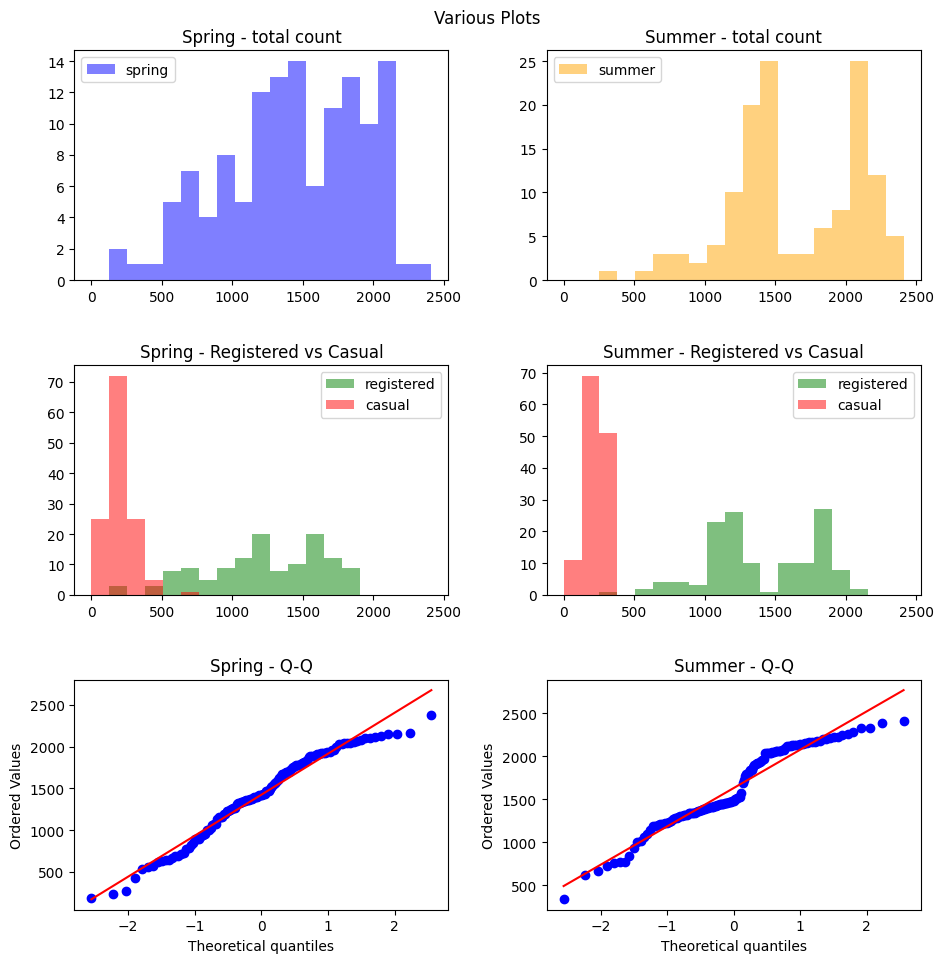

In [8]:
# setup axes
fig, axs = plt.subplots(3,2, figsize=(10,10))
fig.tight_layout(pad=4)
fig.suptitle('Various Plots')

# histogram paramaters
n_bins = 20
x_min = 0
x_max = max(data_spring_eve_workday['cnt'].max(), data_summer_eve_workday['cnt'].max())
bins = np.linspace(x_min, x_max, n_bins)

# total count spring (evening, workday)
axs[0,0].hist(x='cnt', data=data_spring_eve_workday, bins=bins, alpha=0.5, color='blue', label='spring')
axs[0,0].legend()
axs[0,0].title.set_text('Spring - total count')

# total count summer (evening, workday)
axs[0,1].hist(x='cnt', data=data_summer_eve_workday, bins=bins, alpha=0.5, color='orange', label='summer')
axs[0,1].legend()
axs[0,1].title.set_text('Summer - total count')

#  Spring - registered users vs casual
axs[1,0].hist(x='registered', data=data_spring_eve_workday, bins=bins, alpha=0.5, color='green', label='registered')
axs[1,0].hist(x='casual', data=data_spring_eve_workday, bins=bins, alpha=0.5, color='red', label='casual')
axs[1,0].legend()
axs[1,0].title.set_text('Spring - Registered vs Casual')

# summer - registered users vs casual
axs[1,1].hist(x='registered', data=data_summer_eve_workday, bins=bins, alpha=0.5, color='green', label='registered')
axs[1,1].hist(x='casual', data=data_summer_eve_workday, bins=bins, alpha=0.5, color='red', label='casual')
axs[1,1].legend()
axs[1,1].title.set_text('Summer - Registered vs Casual')

# Q-Q plots against norms
stats.probplot(data_spring_eve_workday['cnt'], dist="norm", plot=axs[2,0])
axs[2,0].title.set_text("Spring - Q-Q")
stats.probplot(data_summer_eve_workday['cnt'], dist="norm", plot=axs[2,1])
axs[2,1].title.set_text("Summer - Q-Q")

In [9]:
# Imperical cdf - data is a df, x is a scaler, 
def empircal_cdf(x, data, index, col):
    sum = data.loc[data[index] <= x, col].sum()
    return sum / data[col].sum()

## Test using the Aderson-Darling Modified test
This is testing against the normal distribution, not assuming any parameters about the normal distribution
It does assume our sample data is continuous, but due to the large values of our data we can safely assume this

In [16]:
# what is the range of our sample data
print(f"Spring range: ({data_spring_eve_workday['cnt'].min()}, {data_spring_eve_workday['cnt'].max()})")
print(f"Spring range: ({data_summer_eve_workday['cnt'].min()}, {data_summer_eve_workday['cnt'].max()})")

Spring range: (182, 2376)
Spring range: (337, 2411)


In [ ]:
spring_A2_results = stats.anderson(data_spring_eve_workday['cnt'], dist='norm')
summer_A2_results = stats.anderson(data_summer_eve_workday['cnt'], dist='norm')

print("reject H_0 if A2 > crit_value\nso reject for both seasons")

print(f"stat: {spring_A2_results[0]}")
print(f"crit vals: {spring_A2_results[1]}")
print(f"siglevel: {spring_A2_results[2]}")
print(f'\nif {spring_A2_results[0]:.2f} > {spring_A2_results[1][2]} then can reject Normality')

print("\n")
print(f"stat: {summer_A2_results[0]}")
print(f"crit vals: {summer_A2_results[1]}")
print(f"siglevel: {summer_A2_results[2]}")
print(f'\nif {summer_A2_results[0]:.2f} < {summer_A2_results[1][2]} then can reject Normality')


reject H_0 if A2 > crit_value
so reject for both seasons
stat: 1.135223873136482
crit vals: [0.559 0.637 0.764 0.892 1.06 ]
siglevel: [15.  10.   5.   2.5  1. ]

if 1.14 > 0.764 then can reject Normality


stat: 3.040080089613923
crit vals: [0.56  0.637 0.765 0.892 1.061]
siglevel: [15.  10.   5.   2.5  1. ]

if 3.04 < 0.765 then can reject Normality


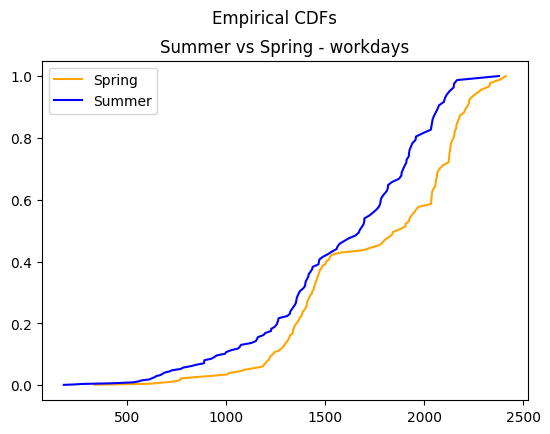

In [ ]:
# Plot cdfs of found Gaussians:
fig, axs = plt.subplots(1)
fig.tight_layout(pad=4)
fig.suptitle('Empirical CDFs')

# Calculate Spring CDF
sorted_spring_data = data_spring_eve_workday.sort_values(by=['cnt'])
ecdf_spring_eve_workday = np.zeros(sorted_spring_data.shape[0])
for i, day in enumerate(sorted_spring_data['cnt']):
    ecdf_spring_eve_workday[i] = empircal_cdf(day, sorted_spring_data, 'cnt', 'cnt')

# Calculate Summer CDF
sorted_summer_data = data_summer_eve_workday.sort_values(by=['cnt'])
ecdf_summer_eve_workday = np.zeros(sorted_summer_data.shape[0])
for i, day in enumerate(sorted_summer_data['cnt']):
    ecdf_summer_eve_workday[i] = empircal_cdf(day, sorted_summer_data, 'cnt', 'cnt')

# Plot Spring vs Summer cdf
axs.plot(sorted_summer_data['cnt'], ecdf_summer_eve_workday, color = 'orange', label='Spring')
axs.plot(sorted_spring_data['cnt'], ecdf_spring_eve_workday, color = 'blue', label='Summer')
axs.title.set_text("Summer vs Spring - workdays")
axs.legend()

Checking if Anderson_Darling statistic rejects samples even generated from a Normal Distribution

The conclusion it does not - for a sample size similar to our data A-D does not reject, not by a long way. Even with a significance level of 15% it still doesn't reject

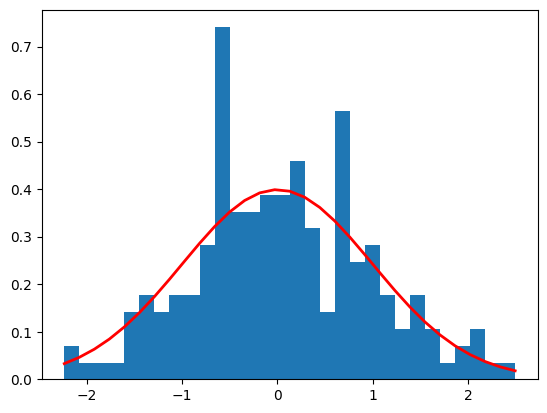

In [ ]:
mu = 0
sigma = 1
norm_sample = np.random.normal(mu, sigma, 180)
count, bins, ignored = plt.hist(norm_sample, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

In [ ]:
print("reject H_0 that norm_sample is from normal dist if A2 > crit_value\n")

norm_sample_A2_results = stats.anderson(norm_sample, dist='norm')

print(f"stat: {norm_sample_A2_results[0]}")
print(f"crit vals: {norm_sample_A2_results[1]}")
print(f"siglevel: {norm_sample_A2_results[2]}")

print(f'\nif {norm_sample_A2_results[0]:.2f} < {norm_sample_A2_results[1][2]} then do not reject H_0')


reject H_0 that norm_sample is from normal dist if A2 > crit_value

stat: 0.3858755163856813
crit vals: [0.564 0.642 0.77  0.899 1.069]
siglevel: [15.  10.   5.   2.5  1. ]

if 0.39 < 0.77 then do not reject H_0
